In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [0]:
import nltk

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet


In [0]:
from nltk import pos_tag

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# BeautifulSoup libraray
from bs4 import BeautifulSoup 

import re # regex

#model_selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation
from sklearn.metrics import accuracy_score,roc_auc_score 
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix




In [8]:
nltk.download("stopwords")
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
df_frame = pd.read_csv("Reviews.csv")

In [0]:
df_frame_copy = frame.copy()

In [25]:
df_frame_copy.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
df_frame_copy=df_frame_copy[['Text','Score']]
df_frame_copy['review']=df_frame_copy['Text']
df_frame_copy['rating']=df_frame_copy['Score']
df_frame_copy.drop(['Text','Score'],axis=1,inplace=True)


In [27]:
print(df_frame_copy.shape)
df_frame_copy.head()

(240754, 2)


,review,rating
0,I have bought several of the Vitality canned d...,5.0
1,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,This is a confection that has been around a fe...,4.0
3,If you are looking for the secret ingredient i...,2.0
4,Great taffy at a great price. There was a wid...,5.0


In [29]:
print(df_frame_copy['rating'].isnull().sum())
df_frame_copy['review'].isnull().sum()

1


1

In [0]:
df_frame_copy.drop_duplicates(subset=['rating','review'],keep='first',inplace=True)

In [31]:
print(df_frame_copy.shape)
df_frame_copy.head()

(190932, 2)


,review,rating
0,I have bought several of the Vitality canned d...,5.0
1,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,This is a confection that has been around a fe...,4.0
3,If you are looking for the secret ingredient i...,2.0
4,Great taffy at a great price. There was a wid...,5.0


In [0]:
def label_sentiment(rating):
  if(rating<=3):
    return 0
  else:
    return 1

In [0]:
df_frame_copy['sentiment']=df_frame_copy['rating'].apply(label_sentiment)

In [34]:
df_frame_copy.drop(['rating'],axis=1,inplace=True)
df_frame_copy.head()
df_frame_copy['sentiment'].value_counts()


1    148089
0     42843
Name: sentiment, dtype: int64

In [0]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

Text(0.5, 1.0, 'Bar plot of sentiments')

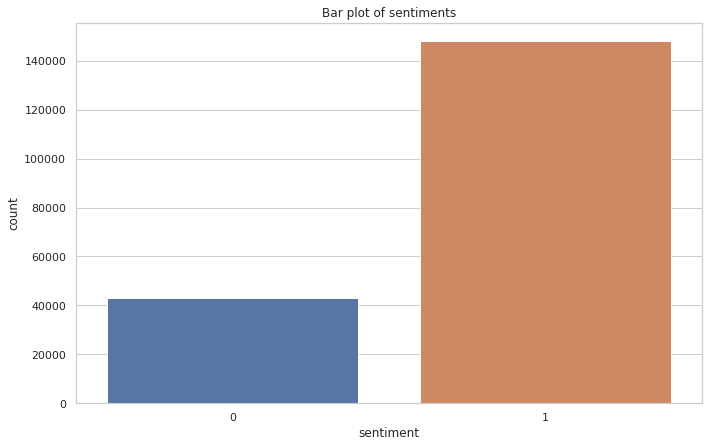

In [39]:
plt.figure(figsize = (10,7))
sns.countplot(df_frame_copy['sentiment'])
plt.title("Bar plot of sentiments")

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
df_frame_copy['review'] = df_frame_copy['review'].apply(lambda x: preprocess_text(str(x)))

In [55]:
df_frame_copy['review'].head()

0    buy several vitality can dog food products fin...
1    product arrive label jumbo salt peanuts peanut...
2    confection around centuries light pillowy citr...
3    look secret ingredient robitussin believe find...
4    great taffy great price wide assortment yummy ...
Name: review, dtype: object

In [56]:
train_df, test_df = train_test_split(df_frame_copy, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (152745, 2)
Test data size :  (38187, 2)


In [0]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['review'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['review'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['sentiment']

In [77]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.fit(X_train,y_train, nb_epoch=3, batch_size=64, validation_split=0.2)

Train on 122196 samples, validate on 30549 samples
Epoch 1/3
122196/122196 [==============================] - 350s 3ms/step - loss: 0.3278 - accuracy: 0.8604 - val_loss: 0.2945 - val_accuracy: 0.8774
Epoch 2/3
122196/122196 [==============================] - 343s 3ms/step - loss: 0.2756 - accuracy: 0.8846 - val_loss: 0.2841 - val_accuracy: 0.8803
Epoch 3/3
122196/122196 [==============================] - 346s 3ms/step - loss: 0.2529 - accuracy: 0.8942 - val_loss: 0.2848 - val_accuracy: 0.8818


In [79]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['review'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['sentiment']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))

Accuracy of the model :  0.8817398591143583
F1-score:  0.9259769210595332


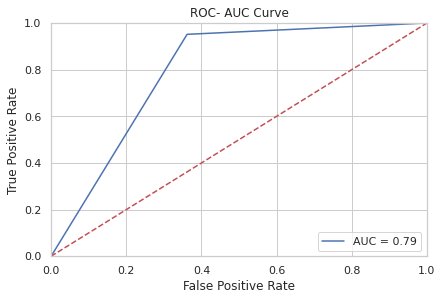

In [84]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC- AUC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()